# Tiny Transformer LM (GPT-style)

This notebook implements a tint decoder-only Transformer language model with:

1. Configuration & Reproducible Seeding
2. Data Utilities (character-level corpus, vocabulary, batching)
3. Core modules:
    - scaled dot product attention
    - multi-head self attention
    - feedforward block
    - transformer block
4. "TinyTransformerLM" model class
5. Training loop with cross-entropy loss
6. Logging, simple run-tracking and checkpoints
7. Sampling / text generation

# The Infrastructure

<b><u>Architecture</b></u>

This project is built on a modular, reproducible infrastructure designed to support GPU-accelerated machine learning while keeping costs low and the development experience seamless. The computational backend runs on a DigitalOcean GPU Droplet, which provides dedicated NVIDIA GPU hardware suitable for training and experimentation. All code execution happens inside a Docker container on the droplet. The containerised environment guarantees reproducibility and isolation: dependencies, Python versions, CUDA-enabled libraries, and runtime behaviour remain consistent across sessions, regardless of host configuration. The project repository on the droplet is mounted into the container at /workspace, allowing source code to be edited externally while still running inside the GPU-enabled runtime.

Development itself is performed locally using PyCharm Professional, which connects to the GPU droplet using an SSH remote interpreter. This allows Python scripts to run directly inside the container on the GPU, while maintaining the full convenience and responsiveness of a local IDE—file browsing, autocomplete, linting, debugging, and version control integration all operate as if the environment were local. Jupyter notebooks are served from within the running container and accessed securely over an SSH port-forwarding tunnel, enabling interactive GPU-backed experimentation through the user’s browser on their local machine.

<b><u>Automated Environment Scaffolding</b></u>

To make the infrastructure fully reproducible—and to minimise cloud compute costs—the project uses a Bash-based automation workflow. A local scaffolding script generates the directory structure and starter files (src/, notebooks/, tests/, scripts/, Dockerfile, requirements.txt, etc.), ensuring a clean, predictable layout across all machines. On the cloud side, the aie_full_setup.sh script serves as a complete end-to-end bootstrapper for fresh GPU droplets. When executed on a new droplet, the script:

1. Installs system dependencies such as Docker, Git, Python, and virtual-environment tools.

2. Pulls the latest version of the project from GitHub.

3. Builds the project’s Docker image.

4. Creates and runs a GPU-enabled container with the project directory mounted into it.

5. Creates and activates a Python virtual environment inside the container.

6. Installs all Python dependencies and optionally CUDA-enabled PyTorch.

7. Drops the user into an interactive shell inside the container, ready for training.

This automation provides a powerful workflow: GPU droplets can be created on demand, fully configured in minutes, used to run model training or experimentation, and then safely destroyed afterwards. Since all source code and notebooks are stored in GitHub, the entire environment can be recreated at any time without keeping expensive GPU instances running. The result is an affordable, scalable, and entirely reproducible development pipeline for AI engineering.

## The Process

1. 'TinyTransformerLM' embeds tokens amd positions -> produces initial representations.
2. It sends then throgh a stack of *TransformerBlocks*
    Each block consists of:
        - *MultiHeadSelfAttention*: tokens communicate with past tokens and gather context
        - *FeedForward*: transforms each tokens representation non-linearly
        - Residual + LayerNorm help stability and flow
3. The final hidden stattes go through a linear projection -> logits
4. Logits give a probability distribution over the *next token* at each position.
5. Training teaches the model to reduce negative log-liklihood (cross entropy).
6. At generation time, the model samples tokens autoregressively using teh same logic.

# The Project - Building a Large Language Model

This large-language-model (LLM) is a GPT style implementation and is flexible in how it represents text, supporting both character-level ('char') and word-level ('word') operation. At the character level, the model treats each individual character as a token, giving it a very small vocabulary and allowing it to learn fine-grained patterns such as spelling, punctuation, and stylistic rhythms. This makes the model simple and extremely general, though sequences become longer and learning long-range structure is harder. At the word level, the model tokenises whole words, dramatically reducing sequence length and enabling it to capture semantic and syntactic relationships more directly. This comes at the cost of a larger vocabulary and reduced ability to generalise to unseen words. Supporting both modes allows you to switch seamlessly between high-resolution modelling of text structure and higher-level linguistic abstraction, depending on the task.

<b>Selection of 'char' or 'word' is performed in the cell 'Config and Runn Tracking'</b>

# Imports

In [26]:
import math
import json
import random
import numpy as np
from dataclasses import dataclass, asdict
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import re

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

# Helper functions

In [27]:
def apply_top_k(logits: Tensor, top_k: int | None) -> Tensor:
    """
    Keep only top_k logits per row, set the rest to -inf.
    logits: (B, V)
    """
    if top_k is None or top_k <= 0:
        return logits

    # Get top_k values; kth value is at index top_k-1
    v, _ = torch.topk(logits, k=top_k, dim=-1)
    kth_values = v[..., -1, None]  # (B, 1)

    # Mask out everything below the kth largest logit
    return torch.where(
        logits < kth_values,
        torch.full_like(logits, -float("inf")),
        logits,
    )


def apply_top_p(logits: Tensor, top_p: float | None) -> Tensor:
    """
    Nucleus (top-p) filtering.
    Keep the smallest number of tokens whose cumulative probability >= top_p.
    logits: (B, V)
    """
    if top_p is None or top_p <= 0.0 or top_p >= 1.0:
        return logits

    # Sort logits descending
    sorted_logits, sorted_indices = torch.sort(logits, dim=-1, descending=True)

    # Convert to sorted probabilities
    sorted_probs = F.softmax(sorted_logits, dim=-1)

    # Cumulative probabilities
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    # Mask tokens where cumulative prob > top_p
    sorted_mask = cumulative_probs > top_p
    # Always keep at least the first token
    sorted_mask[..., 0] = False

    # Set masked logits to -inf
    sorted_logits[sorted_mask] = -float("inf")

    # Unsort back to original token order
    logits_filtered = torch.full_like(logits, -float("inf"))
    logits_filtered.scatter_(-1, sorted_indices, sorted_logits)
    return logits_filtered


# Device and Seeding

In [28]:
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using device: ", device)

using device:  cuda


In [29]:
def set_seed(seed: int, deterministic: bool = True) -> None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.use_deterministic_algorithms(True)

# Config and Run Tracking

In [75]:
"""
Please select character ('char') or word ('word') level implementation
in the line:
    level: str = "word"            # "char" or "word"
"""
@dataclass
class Config:
    # Data
    block_size: int = 16    
    batch_size: int = 32
    train_val_split: float = 0.9
    level: str = "word"            # "char" or "word"

    # Model
    d_model: int = 64       # was 128
    num_heads: int = 2      # was 4
    num_layers: int = 1     # was 2
    d_ff: int = 128         # was 256
    dropout: float = 0.2    # was 0.1

    # Optimization
    learning_rate: float = 3e-4
    max_steps: int = 2000
    eval_interval: int = 200

    # Reproducibility
    seed: int = 123

@dataclass
class RunRecord:
    config: dict
    created_at: str
    run_dir: str
    final_step: int = 0
    final_train_loss: float = float("nan")
    final_val_loss: float = float("nan")

cfg = Config()
cfg

Config(block_size=16, batch_size=32, train_val_split=0.9, level='word', d_model=64, num_heads=2, num_layers=1, d_ff=128, dropout=0.2, learning_rate=0.0003, max_steps=2000, eval_interval=200, seed=123)

In [76]:
print(f"{(cfg.level).upper()} level implementation selected")

WORD level implementation selected


# Run Directory and JSON helpers

In [77]:
BASE_RUN_DIR = Path("runs")

def make_run_dir(base_dir: Path, cfg: Config) -> Path:
    stamp = datetime.now().strftime("%Y%m%dT%H%M%S")
    name = f"{stamp}_seed{cfg.seed}_tiny_transformer"
    run_dir = base_dir / name
    (run_dir / "checkpoints").mkdir(parents=True, exist_ok=True)
    return run_dir

def save_json(path: Path, data: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

# Set seed and create run directory

In [78]:
set_seed(cfg.seed, deterministic=False)
run_dir = make_run_dir(BASE_RUN_DIR, cfg)
print("Run directory:", run_dir)

# Initial run record
record = RunRecord(
    config=asdict(cfg),
    created_at=datetime.now().isoformat(timespec="seconds"),
    run_dir=str(run_dir),
)

save_json(run_dir / "config.json", asdict(cfg))
save_json(run_dir / "run_record.json", asdict(record))

Run directory: runs/20251209T032001_seed123_tiny_transformer


# Add text of Gekko speech from the 1987 movie "Wall Street"

In [79]:
raw_text = """[Gekko:] Well, I appreciate the opportunity you're giving me, Mr. Cromwell, as the single largest 
shareholder in Teldar Paper, to speak. Well, ladies and gentlemen, we're not here to indulge in fantasy, but 
in political and economic reality. America, America has become a second-rate power. Its trade deficit and 
its fiscal deficit are at nightmare proportions. Now, in the days of the free market, when our country was a 
top industrial power, there was accountability to the stockholder. The Carnegies, the Mellons, the men that 
built this great industrial empire, made sure of it because it was their money at stake. Today, management 
has no stake in the company! All together, these men sitting up here own less than 3 percent of the company. 
And where does Mr. Cromwell put his million-dollar salary? Not in Teldar stock; he owns less than 1 percent. 
You own the company. That's right -- you, the stockholder. And you are all being royally screwed over by these, 
these bureaucrats, with their steak lunches, their hunting and fishing trips, their corporate jets and golden 
parachutes. [Cromwell:] This is an outrage! You're out of line, Gekko! [Gekko:] Teldar Paper, Mr. Cromwell, Teldar 
Paper has 33 different vice presidents, each earning over 200 thousand dollars a year. Now, I have spent the last 
two months analyzing what all these guys do, and I still can't figure it out. One thing I do know is that our paper 
company lost 110 million dollars last year, and I'll bet that half of that was spent in all the paperwork going back 
and forth between all these vice presidents. The new law of evolution in corporate America seems to be survival of 
the unfittest. Well, in my book you either do it right or you get eliminated. In the last seven deals that I've been 
involved with, there were 2.5 million stockholders who have made a pretax profit of 12 billion dollars. Thank you. I am 
not a destroyer of companies. I am a liberator of them!The point is, ladies and gentleman, that greed -- for lack of a better 
word -- Greed is good. Greed is right. Greed works. Greed clarifies, cuts through, and captures the essence of the evolutionary 
spirit. Greed, in all of its forms -- greed for life, for money, for love, knowledge -- has marked the upward surge of mankind. 
And greed -- you mark my words -- will not only save Teldar Paper, but that other malfunctioning corporation called the USA. 
Thank you very much."""

print("Corpus length (characters):", len(raw_text))
print(raw_text[:200])

Corpus length (characters): 2439
[Gekko:] Well, I appreciate the opportunity you're giving me, Mr. Cromwell, as the single largest 
shareholder in Teldar Paper, to speak. Well, ladies and gentlemen, we're not here to indulge in fanta


# Vocabulary and Enconde / Decode

In [80]:
print("Tokenization level:", cfg.level)

if cfg.level == "char":
    # ----- Character-level: each character is a token -----
    tokens = list(raw_text)               # e.g. ["T", "o", " ", "b", "e", ...]
    vocab = sorted(set(tokens))
    
    stoi = {ch: i for i, ch in enumerate(vocab)}
    itos = {i: ch for ch, i in stoi.items()}
    
    def encode(s: str):
        """Encode string to list of integer IDs (char-level)."""
        return [stoi[ch] for ch in s]
    
    def decode(ids):
        """Decode list of integer IDs back to string (char-level)."""
        return "".join(itos[i] for i in ids)

elif cfg.level == "word":
    # ----- Word-level: lightweight word + punctuation tokenizer -----
    def tokenize(s: str):
        """
        Split text into words and punctuation.
        Example:
          "Greed is good. Greed is right" ->
          ["Greed", "is", "good", ".", "Greed", "is", "right"]
        """
        # \w+  = one or more word chars (letters/digits/_)
        # \S   = any non-whitespace character (captures punctuation)
        return re.findall(r"\w+|\S", s)
    
    def detokenize(tokens):
        """
        Join tokens back into a string, fixing spaces before punctuation.
        """
        text = " ".join(tokens)
        # Remove space before common punctuation: "word , next" -> "word, next"
        text = re.sub(r"\s+([.,!?;:])", r"\1", text)
        # Optional: "(" + " word" -> "(word"
        text = re.sub(r"([\(\[\{])\s+", r"\1", text)
        return text
    
    tokens = tokenize(raw_text)
    vocab = sorted(set(tokens))
    
    stoi = {tok: i for i, tok in enumerate(vocab)}
    itos = {i: tok for tok, i in stoi.items()}
    
    def encode(s: str):
        """Encode string to list of integer IDs (word-level)."""
        return [stoi[t] for t in tokenize(s)]
    
    def decode(ids):
        """Decode list of integer IDs back to string (word-level)."""
        toks = [itos[i] for i in ids]
        return detokenize(toks)

else:
    raise ValueError(f"Unknown cfg.level: {cfg.level!r}")

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

# Quick sanity test
test = "Greed is good."
encoded = encode(test)
decoded = decode(encoded)
print("test:   ", test)
print("encoded:", encoded)
print("decoded:", decoded)   

Tokenization level: word
Vocab size: 251
test:    Greed is good.
encoded: [22, 126, 111, 4]
decoded: Greed is good.


# Quick test

In [81]:
test = "Greed is good"
encoded = encode(test)
decoded = decode(encoded)
print("test:", test)
print("encoded:", encoded)
print("decoded:", decoded)

vocab_size

test: Greed is good
encoded: [22, 126, 111]
decoded: Greed is good


251

# Create tensor and Train/Val split

In [82]:
# Turn full corpus into a long 1D tensor of token IDs
data = torch.tensor(encode(raw_text), dtype=torch.long)
print("Data shape (number of tokens):", data.shape)

# Train/val split
n = int(len(data) * cfg.train_val_split)
train_data = data[:n]
val_data   = data[n:]
print("Train tokens:", len(train_data), "Val tokens:", len(val_data))

Data shape (number of tokens): torch.Size([532])
Train tokens: 478 Val tokens: 54


# Batch sampling

In [83]:
def get_batch(split: str):
    source = train_data if split == "train" else val_data
    B, T = cfg.batch_size, cfg.block_size

    if len(source) <= T + 1:
        raise ValueError(
            f"Not enough tokens in {split} split "
            f"for block_size={T}. len(source)={len(source)}."
        )

    max_start = len(source) - T - 1
    ix = torch.randint(0, max_start, (B,))
    x = torch.stack([source[i : i + T] for i in ix])
    y = torch.stack([source[i + 1 : i + 1 + T] for i in ix])
    return x.to(device), y.to(device)

# Scaled dot product attention

In [84]:
def scaled_dot_product_attention(q: Tensor, k: Tensor, v: Tensor, mask: Tensor | None = None) -> Tensor:
    """
    q, k, v: [B, H, T, Hd]
    mask:   [T, T] or None (1 = keep, 0 = mask out)
    Returns: [B, H, T, Hd]
    """
    d_k = q.size(-1)
    scores = q @ k.transpose(-2, -1) / math.sqrt(d_k)  # [B, H, T, T]

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
        
    attn = torch.softmax(scores, dim=-1) # should be [B, H, T, T]
    out = attn @ v                       # should be [B, H, T, Hd]
    return out

# Multi Head Self Attention

This class asks "what tokens should I pay attention to". Multi head self attention enables each token in the sequence to look at other tokens, decide which ines arerelevant, and gather information from them.

for language modelling this is how the model:

    - understands dependencies
    - tracks long range relationships
    - carries semantic information forward
    - builds contextual meaning

<b><u>What happens inside this class:</b></u>

At a high level for each position t:
    1. the model creates a *query, key, value* for every token.
    2. it computes *similarity scores* between the query at position t and the keys at all earlier positions.
    3. Using softmax it converts these scores into *attention weights*.
    4. It uses these weights to take a *weighted sum of the value vectors*.
    5. This becomes the representation of the token in the next layer

<b><u>Why "multi-head":</b></u>
Each head can learn a different pattern eg it is possible that:
    * One head tracks syntax
    * One tracks names
    * One tracks verb tense
    * One tracks quotation boundaries, and so on...

<b><u>Why Causal Masking:</b></u>
It is important that token t does not see the future (i.e. t+1, t+2,...) otherwise themodel would cheat during training. Masking ensure that the model is truly able to learn * Given the past, predict the next token*

### MultiHeadSelfAttention teaches the model how tokens relate to each other and forms the backbone of reasoning and contextual understanding in LLM's.

In [85]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, block_size: int):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        mask = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer("causal_mask", mask)

    def forward(self, x: Tensor) -> Tensor:
        B, T, D = x.shape
        H, Hd = self.num_heads, self.head_dim

        q = self.W_q(x)  # [B, T, D]
        k = self.W_k(x)
        v = self.W_v(x)

        # [B, T, D] -> [B,, H, T, Hd]
        q = q.view(B, T, H, Hd).transpose(1, 2)
        k = k.view(B, T, H, Hd).transpose(1, 2)
        v = v.view(B, T, H, Hd).transpose(1, 2)

        out = scaled_dot_product_attention(q, k, v, mask=self.causal_mask[:T, :T])

        # [B, H, T, Hd] -> [B, T, D]
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.W_o(out)
        return out

# FeedForward 

### Purpose in an LLM - "Transform the information that I've gathered"

After self attention mixes information across positions, the feedforward network applies a *nonlinear transformation* to each token independently. This step allows the model to:

    - extract higher level features
    - create richer internal representations
    - perform local computations over each tokesn embedding
    - increase the models expressive capacity

<b><u>What is does</b></u>
Inside the TransformerBlock, FeedForward component is implemented using PyTorch's nn.Sequential, which applies a small neural network of the form:

$\text{FFN}(x) = W_2\,\mathrm{ReLU}(W_1 x)$

This: 

    - Increases dimensionality (*expansion* via W1)
    - Applies a nonlinerity (ReLU)
    - Project back to the original dimension (*compression* via W2)

This pattern (expand -> nonlinear -> compress) lets the transformer model complex functions that cannot be captured by attention alone.
                                

In [86]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)

# TransformerBlock

A *TransformerBlock* combines several key components that work together to progressivley refine token representations as information flows through the model. Each block begins with <i>layer normalisation</i>, followed by <i>multi-head self attention</i>, which allows eaxh token to gather contextual information from earlier tokens in the sequence. A <i>residual connection</i> then preserves the original representation while adding the newly computed attention output, stabilising learning and improving gradient flow. This block applies a second layer normalisation before passing each token through a <i>feedforward network</i>, which performs a nonlinear transformation that enriches and expands the representation locally. Another residdual connection integrates this transformation with the tokens prior state. Stacking multiple blocks in depth enables the model to build a representational hierarchy: lower layers capture syrface-level patterns such as character sequences, middle layers learn grammatical structure and short range semantics, and upper layers develop broader more abstract meaning. Residual pathways throughout the block - mathematically in the form $x_{\text{next}} = x + f(x)$ ensure stable optimisation by allowing gradients to propogate effectively, preventing representational collaose and making deeper transformers trainable

In [87]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        d_model: int,
        num_heads: int,
        d_ff: int,
        block_size: int,
        dropout: float,
    ):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, num_heads, block_size)
        self.ff = FeedForward(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        # GPT-style pre-norm + residual + dropout
        x = x + self.dropout(self.attn(self.ln1(x)))
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x

# Positional Encoding

In [88]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        # pe: (T_max, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (T_max, 1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        # Even indices: sin
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices: cos
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, T_max, d_model)
        # register as buffer so it moves with the module to CUDA, but has no gradients
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        x: (B, T, d_model)
        returns: x + positional encodings for first T positions
        """
        T = x.size(1)
        # self.pe[:, :T, :] -> (1, T, d_model), broadcast over batch
        return x + self.pe[:, :T, :]


# TinyTransformerLM Model

The TinyTransformer "Token -> Meaning -> Prediction" wraps the entire transformer architecture and produces logits at each position, which we use for next-token prediction.

<b><u>Workflow inside the forward</u></b>

1. Token embeddings - convert token id's into vectors
2. Position embeddings - add information about position in the sequence
3. Pass through L Transformer blocks - each block refines and contextualises the embeddings
4. FInal `LayerNorm` and `Linear` Layer - convert the final hidden states into Logits over the vocabulary

<b><u>Why Logits</u></b>

Becuase `CrossEntropyLoss` takes Logits and computes - logP0(Xt | X < t). This creates a next token prediction becuase given input tokens X0, X1, X2,...,X(t - 1) the model predicts a districution over x(t) for every position t in the sequence simultaneously.

In [89]:
class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size: int, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.token_emb = nn.Embedding(vocab_size, cfg.d_model)

        # Sinusoidal positional encodings
        self.pos_encoding = PositionalEncoding(
            d_model=cfg.d_model,
            max_len=cfg.block_size,
        )

        # Dropout applied after adding positional encodings
        self.drop = nn.Dropout(cfg.dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                d_model=cfg.d_model,
                num_heads=cfg.num_heads,
                d_ff=cfg.d_ff,
                block_size=cfg.block_size,
                dropout=cfg.dropout,
            )
            for _ in range(cfg.num_layers)
        ])

        self.ln_f = nn.LayerNorm(cfg.d_model)
        self.head = nn.Linear(cfg.d_model, vocab_size, bias=False)

    def forward(self, idx: Tensor) -> Tensor:
        B, T = idx.shape
        assert T <= self.cfg.block_size, "Sequence length > block_size"

        tok = self.token_emb(idx)          # [B, T, D]
        x = self.pos_encoding(tok)         # add sinusoidal PE
        x = self.drop(x)                   # embedding + position dropout

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)              # [B, T, V]
        return logits


model = TinyTransformerLM(vocab_size, cfg).to(device)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

Number of parameters: 65472


# Loss Estimation Helper

In [90]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):  # a few mini-batches
            xb, yb = get_batch(split)      # <<--- use get_batch, not get_batch_split
            logits = model(xb)
            B, T, V = logits.shape
            loss = F.cross_entropy(
                logits.view(B * T, V),
                yb.view(B * T),
            )
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

# Training Loop with logging & checkpoints

In [91]:
train_steps = []
train_losses_history = []
val_losses_history = []

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

best_val_loss = float("inf")

for step in range(cfg.max_steps):
    # ---- Periodic evaluation ----
    if step % cfg.eval_interval == 0:
        losses = estimate_loss()
        train_loss, val_loss = losses["train"], losses["val"]
        print(f"step {step:5d}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        # Record the losses
        train_steps.append(step)
        train_losses_history.append(train_loss)
        val_losses_history.append(val_loss)

        # Update run record
        record.final_step = step
        record.final_train_loss = float(train_loss)
        record.final_val_loss = float(val_loss)
        save_json(run_dir / "run_record.json", asdict(record))

        # Save checkpoint if best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            ckpt_path = run_dir / "checkpoints" / "best.pt"
            torch.save(model.state_dict(), ckpt_path)
            print(f"  → New best val loss, checkpoint saved to {ckpt_path}")

    # Sample a training batch
    xb, yb = get_batch("train")

    # Forward
    logits = model(xb)                         # [B, T, V]
    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.view(B * T, V),
        yb.view(B * T),
    )

    # Backward
    optimizer.zero_grad()
    loss.backward()
    # Optional gradient clipping
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

# Final save of model
final_ckpt = run_dir / "checkpoints" / "last.pt"
torch.save(model.state_dict(), final_ckpt)
print("Final checkpoint saved to:", final_ckpt)

step     0: train loss 5.6153, val loss 5.6236
  → New best val loss, checkpoint saved to runs/20251209T032001_seed123_tiny_transformer/checkpoints/best.pt
step   200: train loss 3.4468, val loss 5.1323
  → New best val loss, checkpoint saved to runs/20251209T032001_seed123_tiny_transformer/checkpoints/best.pt
step   400: train loss 1.7758, val loss 5.3058
step   600: train loss 1.0004, val loss 5.8663
step   800: train loss 0.6664, val loss 6.2982
step  1000: train loss 0.4694, val loss 6.7149
step  1200: train loss 0.3453, val loss 7.1961
step  1400: train loss 0.2379, val loss 7.4892
step  1600: train loss 0.1941, val loss 7.7137
step  1800: train loss 0.1555, val loss 7.9571
Final checkpoint saved to: runs/20251209T032001_seed123_tiny_transformer/checkpoints/last.pt


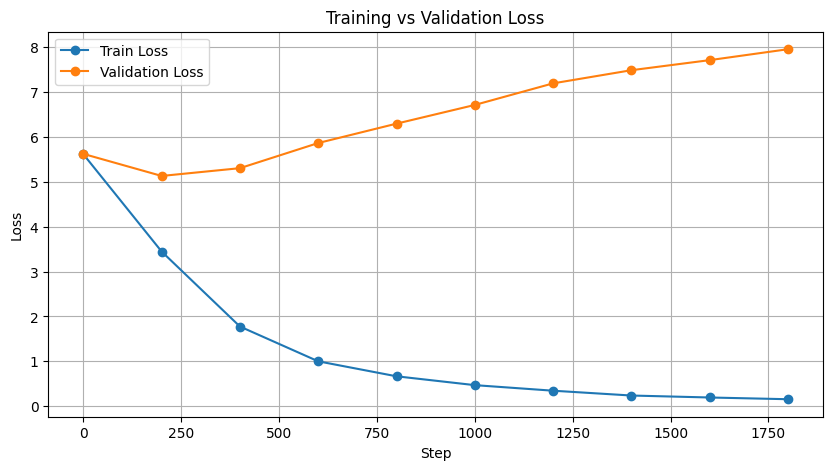

In [92]:
plt.figure(figsize=(10,5))
plt.plot(train_steps, train_losses_history, label="Train Loss", marker='o')
plt.plot(train_steps, val_losses_history, label="Validation Loss", marker='o')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
@torch.no_grad()
def generate(
    model: TinyTransformerLM,
    idx: Tensor,
    max_new_tokens: int,
    *,
    temperature: float = 1.0,
    greedy: bool = False,
    top_k: int | None = None,
    top_p: float | None = None,
) -> Tensor:
    """
    Backwards-compatible generate() function.

    New features:
        - greedy=True          → argmax sampling
        - temperature=τ        → scale logits
        - top_k=k              → keep only top-k tokens
        - top_p=p              → nucleus sampling

    If you call it like before:
        generate(model, idx, max_new_tokens)
    it behaves EXACTLY as the original version (multinomial sampling).
    """
    model.eval()

    for _ in range(max_new_tokens):

        # Use only last block_size tokens as context
        idx_cond = idx[:, -cfg.block_size:]

        # Forward pass: (B, T, V)
        logits = model(idx_cond)

        # Take only the last timestep (B, V)
        logits = logits[:, -1, :]

        # ---- Temperature scaling ----
        logits = logits / temperature

        # ---- Greedy sampling ----
        if greedy:
            next_id = torch.argmax(logits, dim=-1, keepdim=True)  # (B, 1)
        else:
            # ---- Optional top-k ----
            if top_k is not None and top_k > 0:
                v, _ = torch.topk(logits, k=top_k, dim=-1)
                kth = v[:, -1].unsqueeze(-1)
                logits = torch.where(
                    logits < kth,
                    torch.full_like(logits, -float("inf")),
                    logits
                )

            # ---- Optional top-p (nucleus sampling) ----
            if top_p is not None and 0 < top_p < 1.0:
                sorted_logits, sorted_idx = torch.sort(logits, descending=True, dim=-1)
                sorted_probs = torch.softmax(sorted_logits, dim=-1)
                cumulative = torch.cumsum(sorted_probs, dim=-1)

                # Mask tokens after nucleus boundary
                mask = cumulative > top_p
                mask[:, 0] = False  # always keep the highest token
                sorted_logits[mask] = -float("inf")

                # Map back to original index order
                logits = torch.full_like(logits, -float("inf"))
                logits.scatter_(1, sorted_idx, sorted_logits)

            # ---- Sample from distribution ----
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # (B, 1)

        # Append sampled token
        idx = torch.cat([idx, next_id], dim=1)

    return idx


# Sampling / Text generation

In [94]:
# Load best checkpoint (optional, but recommended)
best_ckpt = run_dir / "checkpoints" / "best.pt"
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.eval()

# Choose a prompt
prompt = "Greed is good"
start_ids = torch.tensor([encode(prompt)], dtype=torch.long, device=device)  # (1, T0)

# 1) Greedy sampling
out_greedy = generate(model, start_ids, 50, greedy=True)
print("Greedy:\n", decode(out_greedy[0].tolist()))

# 2) Temperature sampling
out_temp = generate(model, start_ids, 50, temperature=0.7)
print("\nTemperature (τ=0.8):\n", decode(out_temp[0].tolist()))

# 3) Top-k sampling
out_topk = generate(model, start_ids, 50, top_k=20)
print("\nTop-k (k=20):\n", decode(out_topk[0].tolist()))

# 4) Top-p sampling
out_topp = generate(model, start_ids, 50, top_p=0.9)
print("\nTop-p (p=0.9):\n", decode(out_topp[0].tolist()))

# 5) Temperature and Top-p sampling
out_temp_topp = generate(model, start_ids, 50, temperature=0.8, top_p=0.9)
print("\nTemp((τ=0.8) Top-p (p=0.9):\n", decode(out_temp_topp[0].tolist()))


Greedy:
 Greed is good. Cromwell, the last the last the last the last - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Temperature (τ=0.8):
 Greed is good. The put right. rate these Greed this, in going gentleman, ladies and gentleman re, in market. Greed there. Greed a destroyer guys vice the evolutionary back. Now, And in the. different gentlemen is I ' re am free 3,

Top-k (k=20):
 Greed is good. Cromwell that half a - - - - - dollars. Well of a has. In a presidents,, as a - -. Thank dollars are Cromwell, and right power, and fishing and has you either half ' s Mr, and its Teldar

Top-p (p=0.9):
 Greed is good top industrial and I and upward 5 was to ] industrial months, in, the company vice Now as ' re. am Mr. was this shareholder [where; right,. salary am The One dollars is and do seems indulge it point lunches in corporate

Temp((τ=0.8) Top-p (p=0.9):
 Greed is good dollar and different no - power. Greed a rate its Mr. owns still there was Its no own

In [95]:
# Example: Start from "word"
if cfg.level == 'word':
    start_gekko_letter="accountability"
else:
    start_gekko_letter="a"
generate_gekko_tokens=200
start_ids = torch.tensor([[stoi[start_gekko_letter]]], dtype=torch.long, device=device)
sample_ids = generate(model, start_ids, max_new_tokens=generate_gekko_tokens)
print(decode(sample_ids[0].tolist()))

accountability Mr. Greed a. And days Well industrial empire. stock! You fantasy Cromwell last this are forth. America that lack paperwork not greed parachutes, shareholder that greed days. Cromwell profit Greed accountability to the largest new save One Cromwell. Its Well fantasy country, these vice lunches America, there. t not Cromwell power: have it Well country forth these Mr company Its there t dollars. giving power still Mr of trips. surge. survival. made know of evolution for Thank reality to here in it percent! I am lack and save t the save - and I. In a proportions That dollars and. ll together. Greed company? screwed destroyer. proportions deals deficit [, and forth I top of companies Well, free this, the last dollar ll is of the paperwork called its what Gekko get. 5, of the steak single the a clarifies than, and Mellons their put. 200. each profit 200 there have and my year Now, been gentleman was of line own last are who analyzing Thank liberator other word


# Conclusion

## Conclusion: What These Results Say About Overfitting, Data Scarcity, and Sampling

These generation results are entirely consistent with what we saw in the training curves. The model drives the **training loss almost to zero**, while the **validation loss stays high and eventually rises**, even after adding `dropout = 0.2` in an attempt to improve generalisation.  
The dropout helps a little at the margin, but the model still has far more capacity than the dataset can support, so it simply memorises the training text. In other words, the bottleneck is not regularisation—it is the lack of data.

That understanding allows us to explain everything we see across the sampling methods.

### • Greedy sampling
Greedy decoding immediately collapses into loops like *“the last the last the last …”*.  
This is exactly what happens when the next-token distribution is dominated by a few memorised transitions. Greedy decoding exposes that.

### • Temperature sampling (τ = 0.8)
Lowering the temperature adds noise, but it doesn’t magically create structure.  
Because the underlying distribution is already extremely narrow, the model just mixes together half-remembered phrases and odd fragments. It can’t invent anything new — it can only return what it has memorised.

### • Top-k sampling (k = 20)
Restricting the distribution produces cleaner output, but the model still falls back to short, memorised fragments with only light variation.  
Top-k slightly improves coherence, but it doesn’t fix the underlying problem: there is nothing meaningful to sample from.

### • Top-p sampling (p = 0.9)
Top-p gives the most variety. It forces the model to explore beyond the single most likely transitions, which leads to the pseudo-poetic mixtures like  
*“jets. there cuts dollars... survival... evolution... percent!”*  
This looks more interesting, but it is still just recombination of training material, not real generalisation.

### • Temperature + Top-p
The combined sampler gives the most structured output of the set. But even here the model keeps circling back to the same phrases — *“Greed … million year … pretax profit … paperwork …”* — because those are the fragments it has memorised.  
The sampler can change how the model moves through its probability space, but it cannot fix a probability space that has been shaped entirely by overfitting.

---

## Broader Takeaways

These experiments illustrate the core challenge of language modelling in tiny-data regimes:

- With too little data, the model learns **memorisation**, not **generalisation**.
- With **word-level tokenisation**, overfitting shows up as repetition of full sentences or entire phrases.
- With **character-level tokenisation**, the model memorises local patterns (spelling, punctuation) and generates more varied but still shallow text.
- No sampling strategy can compensate for a model whose distributions are shaped almost entirely by memorised fragments.

Modern LLMs avoid all of this by combining:

- extremely large and diverse datasets,  
- subword tokenisation to balance vocabulary size with expressiveness, and  
- architectures whose capacity is aligned with data scale.

This Toy transformer, in contrast, shows in miniature what happens when those ingredients aren’t present: even a well-designed architecture can only remix the fragments it has memorised.

---


# Unit tests

## Scaled dot product attention

In [102]:
def test_scaled_dot_product_attention_tiny_example():
    """
    Sanity check for scaled_dot_product_attention on a tiny, hand-checkable example.

    T = 3, d_k = d_v = 2.
    """
    # ----- Define tiny Q, K, V (3 tokens, 2D vectors) -----
    Q_base = torch.tensor([
        [1.0, 0.0],
        [0.0, 1.0],
        [1.0, 1.0],
    ])
    K_base = torch.tensor([
        [1.0, 0.0],
        [1.0, 1.0],
        [0.0, 1.0],
    ])
    V_base = torch.tensor([
        [1.0, 2.0],
        [0.0, 3.0],
        [1.0, 0.0],
    ])

    # Shape to [B, H, T, d_k] / [B, H, T, d_v] with B=H=1
    q = Q_base.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 2]
    k = K_base.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 2]
    v = V_base.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 2]

    d_k = q.size(-1)

    # ----- Manual step-by-step computation -----
    # QK^T (unscaled scores): [1, 1, T, T]
    scores_unscaled = q @ k.transpose(-2, -1)

    # Scale by 1 / sqrt(d_k)
    scores_scaled = scores_unscaled / math.sqrt(d_k)

    # Row-wise softmax to get attention weights A
    A = torch.softmax(scores_scaled, dim=-1)

    # Multiply by V to get Y
    Y_manual = A @ v  # [1, 1, T, d_v]

    # ----- Use the actual implementation -----
    Y_func = scaled_dot_product_attention(q, k, v, mask=None)


    # ----- Check that implementation matches manual result -----
    assert torch.allclose(Y_manual, Y_func, atol=1e-6), "Mismatch between manual and function outputs!"

# Run the test once
test_scaled_dot_product_attention_tiny_example()


## Self Attention with Causal Mask

In [101]:
def test_scaled_dot_product_attention_causal_mask_tiny_example():
    """
    Sanity check for scaled_dot_product_attention with a causal mask.

    Reuses a tiny T=3, d_k=d_v=2 example and applies a lower-triangular
    causal mask so that position t cannot attend to positions > t.
    """

    # ----- Same tiny Q, K, V as before -----
    Q_base = torch.tensor([
        [1.0, 0.0],
        [0.0, 1.0],
        [1.0, 1.0],
    ])
    K_base = torch.tensor([
        [1.0, 0.0],
        [1.0, 1.0],
        [0.0, 1.0],
    ])
    V_base = torch.tensor([
        [1.0, 2.0],
        [0.0, 3.0],
        [1.0, 0.0],
    ])

    # Shape to [B, H, T, d_k] / [B, H, T, d_v] with B=H=1
    q = Q_base.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 2]
    k = K_base.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 2]
    v = V_base.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 2]

    d_k = q.size(-1)
    T = q.size(-2)

    # ----- Unmasked scores for comparison -----
    scores_unscaled = q @ k.transpose(-2, -1)            # [1, 1, T, T]
    scores_scaled = scores_unscaled / math.sqrt(d_k)     # [1, 1, T, T]
    A_unmasked = torch.softmax(scores_scaled, dim=-1)    # [1, 1, T, T]
    Y_unmasked = A_unmasked @ v                          # [1, 1, T, d_v]

    # ----- Construct causal mask (lower triangular) -----
    # mask[t, t'] = 1 if t' <= t, 0 otherwise
    causal_mask = torch.tril(torch.ones(T, T))           # [T, T]

    # ----- Manual masked computation -----
    scores_scaled_masked = scores_scaled.clone()  # [1, 1, T, T]
    scores_scaled_masked[..., causal_mask == 0] = -float("inf")
    A_masked = torch.softmax(scores_scaled_masked, dim=-1)   # [1, 1, T, T]
    Y_manual_masked = A_masked @ v                           # [1, 1, T, d_v]

    # ----- Use the implementation with mask -----
    Y_func_masked = scaled_dot_product_attention(
        q, k, v, mask=causal_mask
    )  # [1, 1, T, d_v]


    # ----- Check that implementation matches manual result -----
    assert torch.allclose(
        Y_manual_masked, Y_func_masked, atol=1e-6
    ), "Masked attention output does not match manual computation!"

# Run the test once
test_scaled_dot_product_attention_causal_mask_tiny_example()
